In [28]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

## Set Up

In [29]:
"""
CONSTANTS
mass in kg
distance in m
force in kN
angle in degrees
speed in m/s
time in s
"""

# ROCKET
Mr0 = 5.49054e5         # initial mass of rocket
rocket_height = 70      # height of the rocket (not distance from earth)
rocket_diameter = 3.7   # max diameter of rocket
thrust_max1 = 7.56e6    # max thrust of stage 1
thrust_max2 = 9.81e2    # max thrust of stage 2
c = 0.25                # coefficient of drag for the rocket
A = rocket_diameter * np.pi # area that the wind hits

# EARTH
Ve = 0                  # velocity of the earth
Me = 5.97219e24         # mass of the earth
we = 1.675e3            # angular velocity of the earth at the equator
we = 460.0              # angular velocity of the earth at the equator (fixed)??
Re = 6.3781e6           # radius of the earth

# MOON
Vm = 3.683e3            # speed of the moon
Mm = 7.34767309e22      # mass of the moon
wm = 1.67e1             # angular velocity of the moon at its equator
Rm = 1.738e6            # radius of the moon
P = 6.552e2             # period of the orbit of the moon

# SPACE
Lm = 3.84e8             # distance from the earth to the moon
G = 6.673e-11           # graviational constant in (N * m^2) / (kg^2)

# DRAG
p0 = 1.01325e5          # atmospheric pressure at sea level in Pascals
Hn = 1.04e1             # constant for drag force 
K = 1e5                 # Karman line, when drag is zero and space begins

ASSUMPTIONS
1. Rocket, earth, and moon have point mass for the sake of calculating gravity
2. Rocket, earth, and moon are the only objects for the sake of calculating gravity (no influence of the sun, stars, etc)
3. Rocket, earth, and moon lie on a 2D plane
4. Moon's orbit is perfectly circular
5. Rocket's mass does not change
6. Rocket is single stage

ADDITIONAL COMPLEXITY
1. Rocket's mass changes over time due to propellent use
2. Moon's orbit is slightly elliptical
3. Find orbital path in 3D space
4. Calculate optimal time to take off
5. Land on the moon
6. Take off from somewhere besides the equate and orbit the moon someone besides the equator
7. Calculate optimal time to release second stage

REDUCED COMPLEXITY
1. Moon does not move

In [30]:
# initial variables and endpoints
# position
xrx0 = Re               # initial x position of rocket
xry0 = 0                # initial y position of rocket
xex0 = 0                # initial x position of earth
xey0 = 0                # initial y position of earth
xmx0 = Lm               # initial x position of moon
xmy0 = 0                # initial y position of moon
# velocity
vrx0 = 0                # initial x velocity of rocket
vry0 = we               # initial y velocity of rocket
vex0 = 0                # initial x velocity of earth
vey0 = 0                # initial y velocity of earth
vmx0 = 0                # initial x velocity of moon
vmy0 = Vm               # initial y velocity of moon
# initial acceleration is all zero

# position
xr0 = np.array([xrx0, xry0])     # IC
xe0 = np.array([xex0, xey0])
xm0 = np.array([xmx0, xmy0])
# velocity
vr0 = np.array([vrx0, vry0])     # IC
ve0 = np.array([vex0, vey0])
vm0 = np.array([vmx0, vmy0])
# acceleration
ar0 = np.array([0,0])           # IC
ae0 = np.array([0,0])
am0 = np.array([0,0])

tht0 = 0                # initial angle between earth and rocket
phi0 = 0                # initial angle between earth and moon

# control
ux0 = 0                 # initial x thrust of rocket
uy0 = 0                 # initial y thrust of rocket
u = np.array([ux0, uy0])


# final endpoints. idk bro
hf = 1e2                # final distance between rocket and moon
vf = 1e1                # orbital speed of the moon but idk what that is
# xrxf = moon_position(tf) * np.cos(phi_tf) + hf * np.cos(phi_tf + 90)
# xryf = moon_position(tf) * np.sin(phi_tf) + hf * np.sin(phi_tf + 90)
# vrxf = Vm * np.cos(phi_tf) + vf * np.cos(phi_tf + 90)
# vryf = Vm * np.sin(phi_tf) + vf * np.sin(phi_tf + 90)

# xrf = np.array([xrxf, xryf])
# vrf = np.array([vrxf, vryf])

## Update state equations

### Helper Helper functions

In [31]:
def find_angle(pos):
    return np.arcsin(pos[1] / np.linalg.norm(pos))

def er_cos(d, theta, phi):
    """
    Calculate the cosine of the angle between the rocket, earth, and the vertical.

    @param d: (float) Distance from the rocket to the center of the Earth.
    @param theta: (float) Angle between the rocket's position vector and the horizontal axis.
    @param phi: (float) Angle between the moon's position vector and the center of the Earth.

    @return: (float) The cosine of the angle.
    """
    # note: cos(i)
    return (d**2 + (d*np.sin(theta) - d*np.cos(theta)*np.tan(phi) )**2 - (d*np.cos(theta) / np.cos(phi))**2)


def em_sin(pos, moon, theta, phi):
    """
    Calculate the sine of the angle between the rocket, Earth, and the Moon.

    @param pos: (ndarray) Position vector of the rocket.
    @param moon: (ndarray) Position vector of the Moon.
    @param theta: (float) Angle between the rocket's position vector and the horizontal axis.
    @param phi: (float) Angle between the moon's position vector and the center of the Earth.

    @return: (float) The sine of the angle.
    """
    # note: sin(x)
    return Lm / np.linalg.norm(moon - pos) * np.sin(theta - phi)


def er_sin(d, theta, phi):
    """
    Calculate the sine of the angle between the rocket, Earth, and the vertical.

    @param d: (float) Distance from the rocket to the center of the Earth.
    @param theta: (float) Angle between the rocket's position vector and the horizontal axis.
    @param phi: (float) Angle between the Moon and the center of the Earth.

    @return: (float) The sine of the angle.
    """
    # note: sin(i)
    return d * np.cos(theta) * np.sin(theta) / (d*np.sin(theta) - d*np.cos(theta)*np.tan(phi))


def em_cos(d, pos, moon):
    """
    Calculate the cosine of the angle between the rocket, Earth, and the Moon.

    @param d: (float) Distance from the rocket to the center of the Earth.
    @param pos: (ndarray) Position vector of the rocket.
    @param moon: (ndarray) Position vector of the Moon.

    @return: (float) The cosine of the angle.
    """
    # note: cos(x)
    dm = np.linalg.norm(moon - pos)
    return (d**2 + dm**2 - Lm**2) / (2*d*dm)

### Force helpers

In [32]:
def rocket_mass(t):
    """
    Calculate the mass of the rocket at a given time.

    @param t: (float) Time elapsed since the start of the simulation.

    @return: (float) Mass of the rocket.
    """
    # TODO this should depend on how much fuel has been spent but just returns a constant for now
    return Mr0


def moon_cos(pos, moon, theta, phi):
    """
    Calculate the cosine component of the force exerted on the rocket by the Moon.

    @param pos: (ndarray) Position vector of the rocket.
    @param moon: (ndarray) Position vector of the Moon.
    @param theta: (float) Angle between the rocket's position vector and the horizontal axis.
    @param phi: (float) Angle between the Moon and the horizontal axis.

    @return: (float) Cosine component of the force.
    """
    d = np.linalg.norm(pos)
    return er_cos(d, theta, phi) * em_sin(pos, moon, theta, phi) - er_sin(d, theta, phi) * em_cos(d, moon)


def moon_sin(pos, moon, theta, phi):
    """
    Calculate the sine component of the force exerted on the rocket by the Moon.

    @param pos: (ndarray) Position vector of the rocket.
    @param moon: (ndarray) Position vector of the Moon.
    @param theta: (float) Angle between the rocket's position vector and the horizontal axis.
    @param phi: (float) Angle between the Moon and the center of the Earth.

    @return: (float) Sine component of the force.
    """
    d = np.linalg.norm(pos)
    return er_cos(d, theta, phi) * em_cos(d, moon) - er_sin(d, theta, phi) * em_sin(pos, moon, theta, phi)


def gravity_mag(x, t, moon=np.array([0, 0])):
    """
    Calculate the magnitude of the gravitational force acting on the rocket.

    @param x: (ndarray) Position vector of the rocket.
    @param t: (float) Time elapsed since the start of the simulation.
    @param moon: (ndarray) Position vector of the Moon. Defaults to 0, indicating Earth's gravity.

    @return: (float) Magnitude of the gravitational force.
    """
    mass = Me if moon==0 else Mm
    return G * mass * rocket_mass(t) * np.linalg.norm(moon - x)


def density(height):
    """
    Calculate the air density at a given altitude.

    @param height: (float) Altitude above sea level.

    @return: (float) Air density at the given altitude.
    """
    return p0 * np.exp(-height / Hn)

### Force functions

In [33]:
def earth_gravity(x, t, theta, x_dir=True):
    """
    Calculate the gravitational force exerted on the rocket by the Earth.

    @param x: (ndarray) Position vector of the rocket.
    @param t: (float) Time elapsed since the start of the simulation.
    @param theta: (float) Angle between the rocket's position vector and the horizontal axis.
    @param x_dir: (bool) Flag indicating whether to calculate force in the x-direction (True) or y-direction (False). Default is True.

    @return: (float) Magnitude of the gravitational force in the specified direction.
    """
    angle = np.cos(theta) if x_dir else np.sin(theta)
    return gravity_mag(x, t) * angle


def moon_gravity(x, t, moon, theta, phi, x_dir=True):
    """
    Calculate the gravitational force exerted on the rocket by the Moon.

    @param x: (ndarray) Position vector of the rocket.
    @param t: (float) Time elapsed since the start of the simulation.
    @param moon: (ndarray) Position vector of the Moon.
    @param theta: (float) Angle between the rocket's position vector and the horizontal axis.
    @param phi: (float) Angle between the Moon and the center of the Earth.
    @param x_dir: (bool) Flag indicating whether to calculate force in the x-direction (True) or y-direction (False). Default is True.

    @return: (float) Magnitude of the gravitational force in the specified direction.
    """
    direction = moon_cos(x, moon, theta, phi) if x_dir else moon_sin(x, moon, theta, phi)
    return gravity_mag(x, t, moon) * direction


def drag(y, theta=None, x=True):
    """
    Compute the force due to drag from the atmosphere. 
    Returns zero if the rocket has passed the Karman line.

    @param: y (ndarray) - 4D array of floats 
                            x position and y position of the rocket in km, 
                            x velocity and y velocity of the rocket in km/s
    @param: theta (float) - angle between the y-axis and the rocket from start point in degrees
    @param: x (boolean) - True if the force should be returned in the x direction, false for the y direction

    @returns: force (float) - Force due to drag in the desired direction
    """
    pos = y[:2]
    vel = y[2:]
    height = np.linalg.norm(pos - Re)
    if height < K:
        i = 0 if x else 1
        angle = np.cos(theta) if x else np.sin(theta)
        return 0.5 * c * A * density(height) * vel[i]**2 / Mr0 #* angle**2 / Mr0
    return 0


def ux():
    """
    Control?
    """
    return 0


def uy():
    """
    Control?
    """
    return 0


def acceleration(t, x, dx, moon, x_dir=True):
    """
    Calculate the total acceleration experienced by the rocket.

    @param t: (float) Time elapsed since the start of the simulation.
    @param x: (ndarray) Position vector of the rocket.
    @param dx: (ndarray) Velocity vector of the rocket.
    @param moon: (ndarray) Position vector of the Moon.
    @param x_dir: (bool) Flag indicating whether to calculate acceleration in the x-direction (True) or y-direction (False). Default is True.

    @return: (float) Total acceleration of the rocket in the specified direction.
    """
    control = ux() if x_dir else uy()
    theta = find_angle(x)
    phi = find_angle(moon)
    return control - \
            earth_gravity(x, t, theta, x_dir) + \
            moon_gravity(x, t, moon, theta, phi, x_dir) - \
            drag(x, dx, theta, x_dir)

## ODE

In [38]:
def gravity(x, x_dir=True, moon=np.array([Lm, 0]), rocket=Mr0):
    """
    Calculate the magnitude of the gravitational force acting on the rocket.

    @param x: (ndarray) Position vector of the rocket.
    @param t: (float) Time elapsed since the start of the simulation.
    @param moon: (ndarray) Position vector of the Moon. Defaults to 0, indicating Earth's gravity.

    @return: (float) Magnitude of the gravitational force.
    """
    mass = Me if np.all(moon == 0) else Mm
    id = 0 if x_dir else 1
    # since we want acceleration and not force, we don't multiply by the mass of the rocket
    return G * mass * (moon[id] - x[id]) / ((moon[0] - x[0])**2 + (moon[1] - x[1])**2)**(1.5)


def moon_position(t):
    """
    Calculate the position vector of the Moon at a given time.

    @param t: (float) Time elapsed since the start of the simulation.

    @return: (ndarray) Position vector of the Moon.
    """
    #TODO make it so that the moon starts at an arbitrary position instead of (Lm, 0)
    t_norm = t * (2 * np.pi) / P
    return Lm, 0
    # return Lm*np.cos(t_norm), Lm*np.sin(t_norm)



# Function that will calculate if the rocket is in the atmosphere of the earth or not
def in_atmosphere(x):
    """
    Calculate if the rocket is in the atmosphere of the Earth.

    @param x: (ndarray) Position vector of the rocket.

    @return: (bool) True if the rocket is in the atmosphere, False otherwise.
    """
    return np.linalg.norm(x) < K

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
Singular Jacobian encountered when solving the collocation system on iteration 1. 
Maximum relative residual: 2.12e+00 
Maximum boundary residual: 3.82e+08
2,    Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
Singular Jacobian encountered when solving the collocation system on iteration 1. 
Maximum relative residual: 2.12e+00 
Maximum boundary residual: 3.82e+08
4,    Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
Singular Jacobian encountered when solving the collocation system on iteration 1. 
Maximum relative residual: 2.12e+00 
Maximum boundary residual: 3.82e+08
6,    Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
Singular Jacobian encountered when solving the collocation system on iteration 1. 
Maximum relative residual: 2.12e+00 
Maximum boundary residual: 3.82e+08
8,    Iteration    Max residual  Max BC residual  Total nodes  

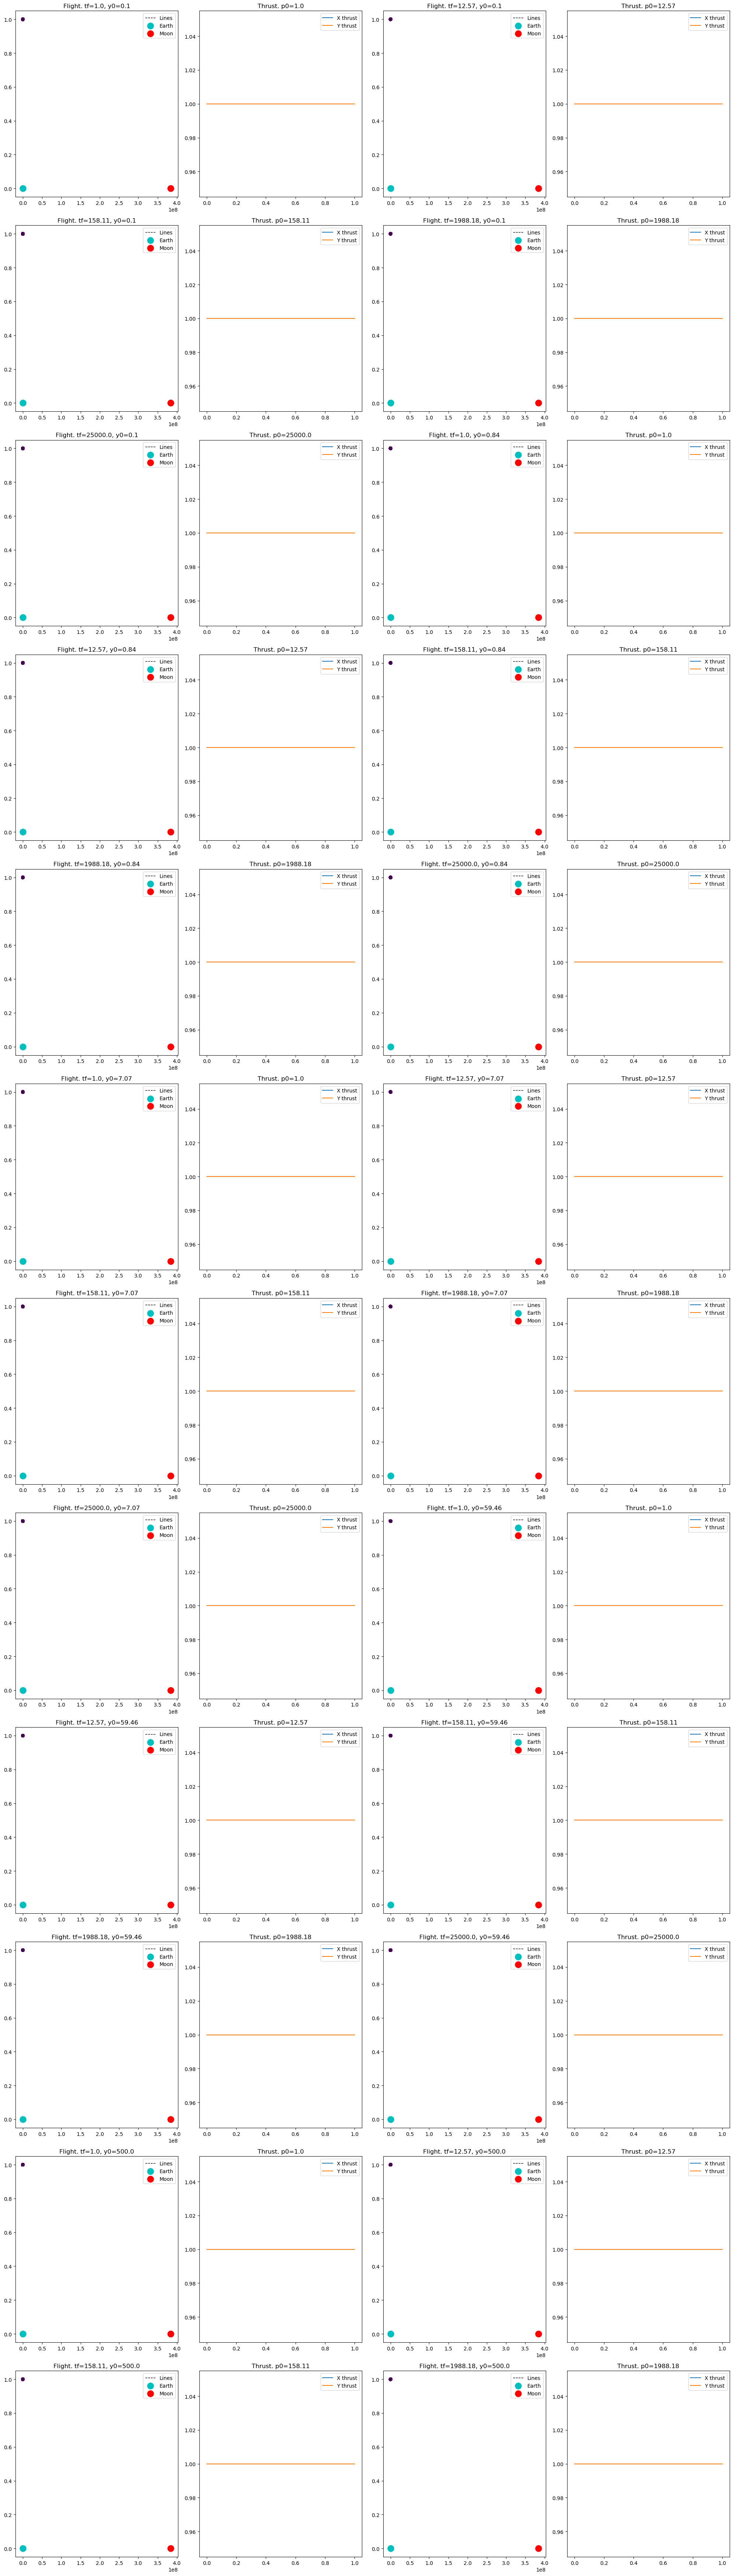

In [41]:
# Algorithm 21.2

# set up the right hand side of the ODE, with the parameter
n = 1000
dim = 8
final_time = 250000*2
guess = 2
cost = 1

# def drag_apply

def update(t,z,p):
    tf = p[0]
    pos = z[:2]
    mx, my = moon_position(t*tf)
    mass_r = rocket_mass(t*tf)
    x = z[0]
    y = z[1]
    p1 = z[4]
    p2 = z[5]
    p3 = z[6]
    p4 = z[7]
    
    ux = p3 / (2*mass_r) / cost
    uy = p4 / (2*mass_r) / cost
    ux = np.array([min(thrust_max1, c) if c > 0 else max(-thrust_max1, c) for c in ux])
    uy = np.array([min(thrust_max1, c) if c > 0 else max(-thrust_max1, c) for c in uy])

    dm = ((mx-x)**2 + (my-y)**2)**0.5       # distance to moon
    de = (x**2 + y**2)**0.5                 # distance to earth

    return np.vstack((z[2], 
                        z[3], 
                        (ux / mass_r - gravity(pos) + gravity(pos, moon=np.array([mx, my])) - in_atmosphere(z[:2])*drag(z)), 
                        (uy / mass_r - gravity(pos, x_dir=False) - gravity(x, x_dir=False, moon=np.array([mx, my])) - in_atmosphere(z[:2])*drag(z, x=False)),
                        # p1 prime
                        -G*(p4*3*(-Mm*(mx-x)*(my-y) / dm**5 + \
                                Me*x*y / de**5) + \
                            p3*((3*Mm*(mx-x)**2 / dm**5 - \
                                Mm / dm**3 + \
                                    3*Me*x**2 / de**5 - \
                                        Me / de**3))),
                        # p2 prime
                        -G*(p3*3*((-Mm*(mx-x)*(my-y)) / dm**5 + \
                                Me*x*y / de**5) + \
                            p4*((3*Mm*y**2 / dm**5) - \
                                (Mm / dm**3) + \
                                    (3*Me*y**2 / de**5) - \
                                        (Me / de**3))),
                        # p3 prime
                        -p1 + c*A*in_atmosphere(z[:2])*z[2] / (mass_r),
                        # p4 prime
                        -p2 + c*A*in_atmosphere(z[:2])*z[3] / (mass_r)
                        ))

# set up the endpoint conditions. The final one is H(tf) = 2a( -tf-1)
def bc(ya,yb,p):
    tf = p[0]
    moon_pos = moon_position(tf)
    theta = np.arctan2(moon_pos[0], moon_pos[1]) + 90
    return np.array([ya[0]-Re,      # start x
                     ya[1]-0,       # start y
                     ya[2]-0,       # start x'
                     ya[3]-we,      # start y'
                     yb[0]-moon_pos[0] - (Rm-hf)*np.cos(theta),           # end x
                     yb[1]-moon_pos[1] - (Rm-hf)*np.sin(theta), # end y
                     yb[2]-vf*np.cos(theta),      # end x'
                     yb[3]-vf*np.sin(theta),      # end y'
                     (tf-final_time)])    

# construct the solution using solve_bvp. We use an initial guess
# of tf=1 as that is the value we are forcing the solution to be close to.
count = 0
r1 = 5
r2 = 5
plt.figure(figsize=(20, 70))
for i, y_guess in enumerate(np.geomspace(0.1, 500, num=r1)):
    for j, p_guess in enumerate(np.geomspace(1, 25000, num=r2)):
        # y_guess = 0.84
        # p_guess = 250000
        t = np.linspace(0,1,n)
        y = np.ones((dim, t.size))
        # set ends to boundary conditions

        # p0 = np.array([2])
        p0 = np.array([p_guess])
        res = solve_bvp(update, bc, t, y, p=p0, max_nodes=50000, verbose=2)

        # plot the results and print out the optimal final time t_f
        t_plot = np.linspace(0, 1, n)
        # print(res.sol(t_plot).shape)
        x_plot = res.sol(t_plot)[0]
        y_plot = res.sol(t_plot)[1]
        px_plot = res.sol(t_plot)[6]
        py_plot = res.sol(t_plot)[7]
        ux_plot = px_plot
        uy_plot = py_plot

        plt.subplot((r2*r1)//2, 4, 1+count)
        # plt.plot(t_plot, x_plot)
        # plt.plot(t_plot, y_plot)
        # plt.plot(x_plot, y_plot, label="Flight")
        plt.scatter(x_plot, y_plot, c=x_plot, cmap='viridis')
        plt.plot(x_plot, y_plot, c='k', linestyle='--', linewidth=1, label='Lines')
        plt.scatter(0,0, label="Earth", s=150, c="c")
        plt.scatter(moon_position(final_time)[0], moon_position(final_time)[1], label="Moon", s=150, c="r")
        plt.legend()
        plt.title(f"Flight. tf={round(res.p[0], 2)}, y0={round(y_guess, 2)}")
        # plt.xlim(0, Lm*1.2)
        plt.set_cmap("viridis")

        plt.subplot((r2*r1)//2, 4, 2+count)
        plt.plot(t_plot, ux_plot, label="X thrust")
        plt.plot(t_plot, uy_plot, label="Y thrust")
        plt.title(f"Thrust. p0={round(p_guess, 2)}")
        plt.legend()
        count += 2
        if count >= ((r2 * r1) // 2) * 4:
            break
        print(count, end=", ")
    #     break
    # break
plt.tight_layout()
plt.show()

C:\Users\dalli\AppData\Local\Temp\ipykernel_14352\1822422475.py:41: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


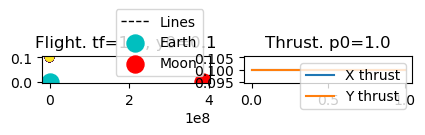

In [36]:
# construct the solution using solve_bvp. We use an initial guess
# of tf=1 as that is the value we are forcing the solution to be close to.
count = 0
r1 = 5
r2 = 5
plt.figure(figsize=(10, 5))
t = np.linspace(0,1,n)
y = np.ones((dim, t.size)) * y_guess
# p0 = np.array([2])
p0 = np.array([p_guess])
res = solve_bvp(update, bc, t, y, p=p0)

# plot the results and print out the optimal final time t_f
t_plot = np.linspace(0, 1, n)
# print(res.sol(t_plot).shape)
x_plot = res.sol(t_plot)[0]
y_plot = res.sol(t_plot)[1]
px_plot = res.sol(t_plot)[6]
py_plot = res.sol(t_plot)[7]
ux_plot = px_plot
uy_plot = py_plot

plt.subplot((r2*r1)//2, 4, 1+count)
# plt.plot(t_plot, x_plot)
# plt.plot(t_plot, y_plot)
# plt.plot(x_plot, y_plot, label="Flight")
plt.scatter(x_plot, y_plot, c=x_plot, cmap='viridis')
plt.plot(x_plot, y_plot, c='k', linestyle='--', linewidth=1, label='Lines')
plt.scatter(0,0, label="Earth", s=150, c="c")
plt.scatter(Lm, 0, label="Moon", s=150, c="r")
plt.legend()
plt.title(f"Flight. tf={round(res.p[0], 2)}, y0={round(y_guess, 2)}")
# plt.xlim(0, Lm*1.2)
plt.set_cmap("viridis")

plt.subplot((r2*r1)//2, 4, 2+count)
plt.plot(t_plot, ux_plot, label="X thrust")
plt.plot(t_plot, uy_plot, label="Y thrust")
plt.title(f"Thrust. p0={round(p_guess, 2)}")
plt.legend()
plt.tight_layout()
plt.show()